In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import allel
from os.path import join
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import admix
from scipy import stats
from functools import reduce
from utils import impute_dataset, marginal

import myvariant
mv = myvariant.MyVariantInfo()

def get_rsid(snp):
    fields = snp.split(":")
    snp = fields[0] + ":" + "g." + fields[1] + fields[2] + ">" + fields[3]
    return mv.getvariant(snp, assembly='hg38', fields="dbsnp.rsid")["dbsnp"]["rsid"]

def pval2zsc(pval):
    return -stats.norm.ppf(pval)

cycle_colors = ["#1b9e77", "#d95f02", "#7570b3"]
cycle_markers = ['+', 'o', '*']
col_trait = ["cholesterol", "ldl_direct"]
col_cov = ["AGE", "SEX", "dilution_factor"] + [f"PC{i + 1}" for i in range(10)]

In [5]:
# trait = "ldl_direct"
# plink_assoc = []
# for i_chr in range(1, 23):
#     plink_assoc.append(pd.read_csv(f"04_assoc/plink_assoc/{trait}.{i_chr}.assoc.linear", delim_whitespace=True))
# plink_assoc = pd.concat(plink_assoc, axis=0)

# assoc = []
# for i_chr in range(1, 23):
#     assoc.append(pd.read_csv(f"04_assoc/assoc/{trait}.chr{i_chr}.csv"))
# assoc = pd.concat(assoc, axis=0)

# fig, ax = plt.subplots(dpi=150, figsize=(3, 3))
# plt.scatter(-np.log10(plink_assoc.P), -np.log10(assoc.ATT), s=1., )
# plt.axline((0, 0), slope=1, color='k', ls='--')

# for method in ["ATT", "SNP1", "TRACTOR", "ADM"]:
#     chisq = pval2zsc(assoc[method]) ** 2
#     print(f"{np.quantile(chisq, 0.5) / stats.chi2.ppf(0.5, 1): .3f}")

# Association testing

In [6]:
window_size = 50_000
dict_region = {
    "APOE": [19, 44905796, 44909393],
    "LDLR": [19, 11089432, 11133820],
    "PCSK9": [1, 55039548, 55064852],
    "SORT1":  [1, 109309574, 109397939]
}

dict_ds_imputed = dict()

for gene in dict_region:
    region = dict_region[gene]
    gene_chr, gene_start, gene_stop = region
    region_text = f"chr{gene_chr}:{gene_start - window_size}-{gene_stop + window_size}"
    ds = xr.open_zarr(f"04_assoc/dataset/chr{gene_chr}.zarr", chunks=None)
    path_imputed = f"02_impute/processed/chr{gene_chr}/chr{gene_chr}.sample.imputed.vcf.gz"
    vcf = allel.read_vcf(path_imputed, region=region_text)

    ds_imputed = impute_dataset(vcf, ds)

    region_snp = ds.snp[(gene_start - window_size < ds.position) & (ds.position < gene_stop + window_size)]
    ds_subset = ds.sel(snp=region_snp)
    assert (ds_imputed.sel(snp=ds_subset.snp).lanc == ds_subset.lanc).all()
    
    for col_trait in ["cholesterol", "ldl_direct"]:
        
        region_att = marginal(ds_imputed, col_pheno=col_trait, col_cov=col_cov, method="ATT")
        region_snp1 = marginal(ds_imputed, col_pheno=col_trait, col_cov=col_cov, method="SNP1")
        region_tractor = marginal(ds_imputed, col_pheno=col_trait, col_cov=col_cov, method="TRACTOR")
        region_adm = marginal(ds_imputed, col_pheno=col_trait, col_cov=col_cov, method="ADM")
        
        ds_imputed = ds_imputed.assign_coords({
            f"assoc_{col_trait}_att": ("snp", region_att.P.values),
            f"assoc_{col_trait}_snp1": ("snp", region_snp1.P.values),
            f"assoc_{col_trait}_tractor": ("snp", region_tractor.P.values),
            f"assoc_{col_trait}_adm": ("snp", region_adm.P.values),
        })
    dict_ds_imputed[gene] = ds_imputed


 54%|█████▍    | 410/760 [00:04<00:03, 95.87it/s]


KeyboardInterrupt: 

In [20]:
cycle_colors = ["#66c2a5", "#fc8d62", "#8da0cb"]
cycle_markers = ['*', 'o', 'X']

trait: cholesterol, rsid: rs7412, att: 2.28e-31, snp1: 4.70e-31, tractor: 1.22e-29


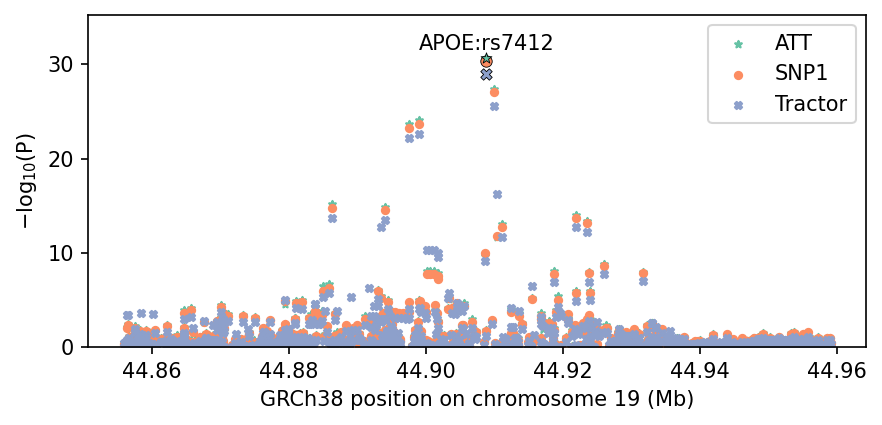

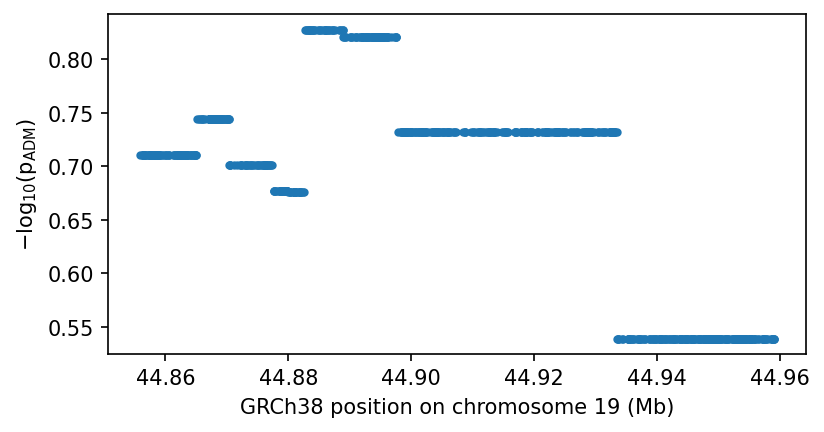

trait: ldl_direct, rsid: rs7412, att: 9.09e-51, snp1: 1.56e-50, tractor: 3.22e-48


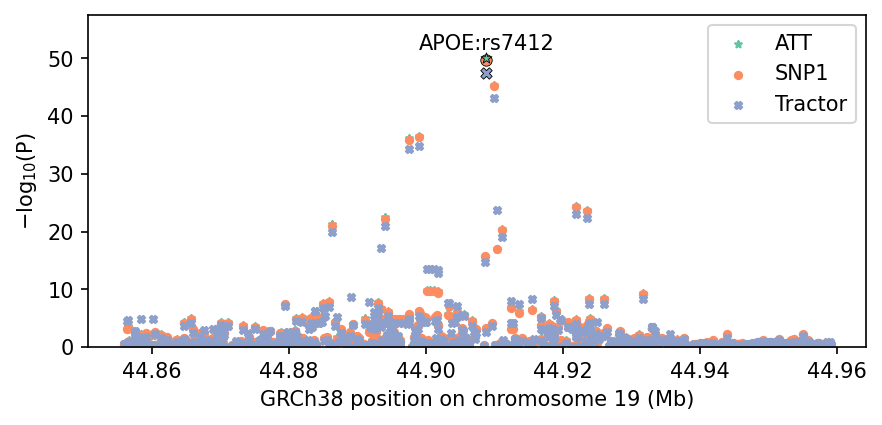

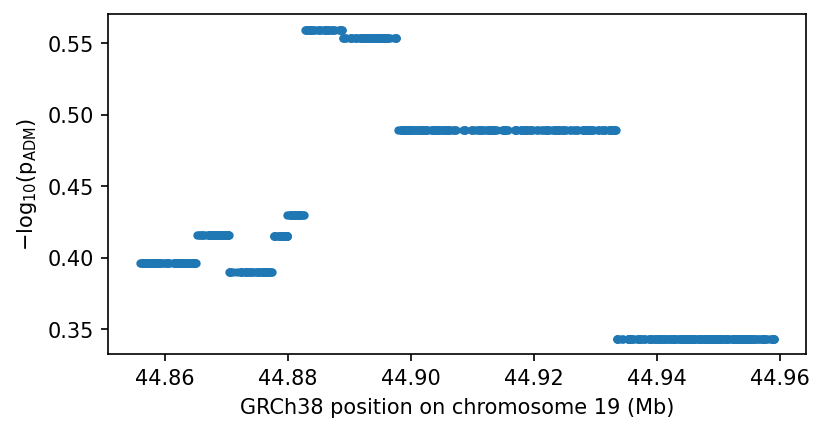

trait: cholesterol, rsid: rs138294113, att: 5.59e-09, snp1: 6.58e-09, tractor: 2.78e-08


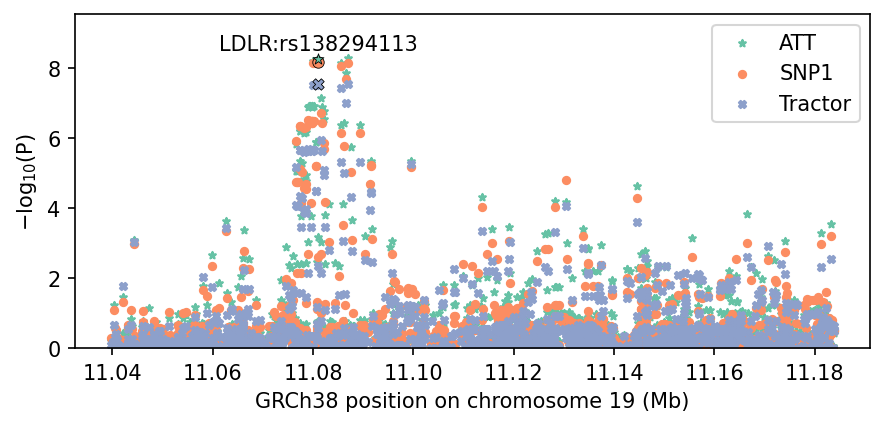

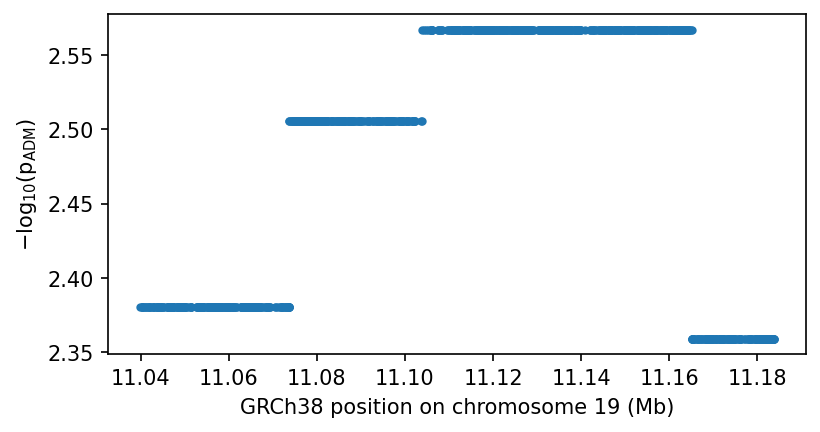

trait: ldl_direct, rsid: rs138294113, att: 2.30e-10, snp1: 2.76e-10, tractor: 1.65e-09


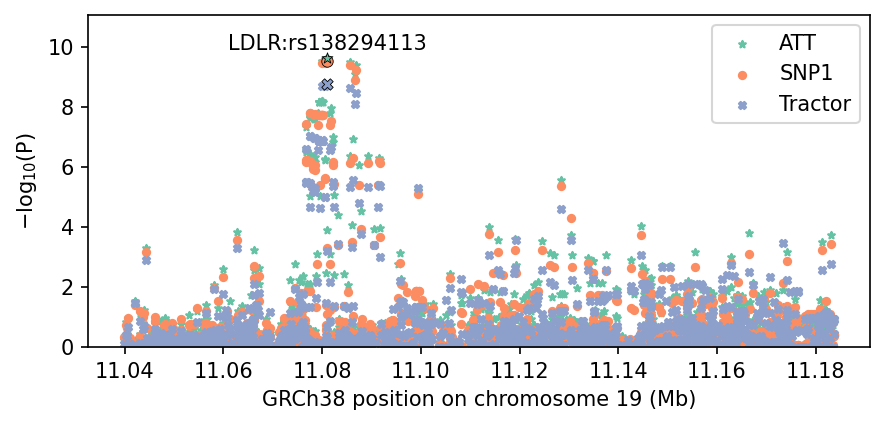

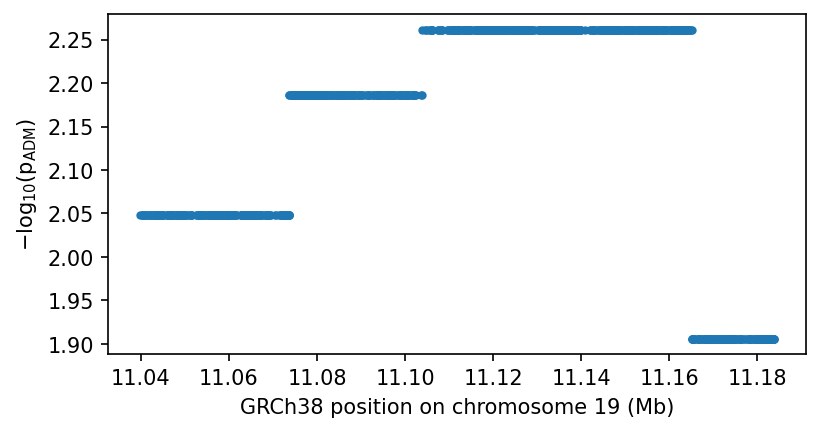

trait: cholesterol, rsid: rs11804420, att: 4.02e-10, snp1: 3.43e-09, tractor: 2.09e-08


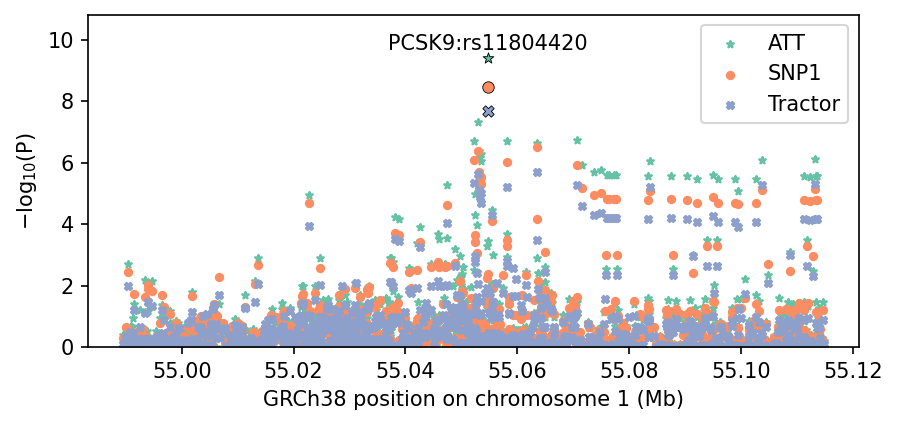

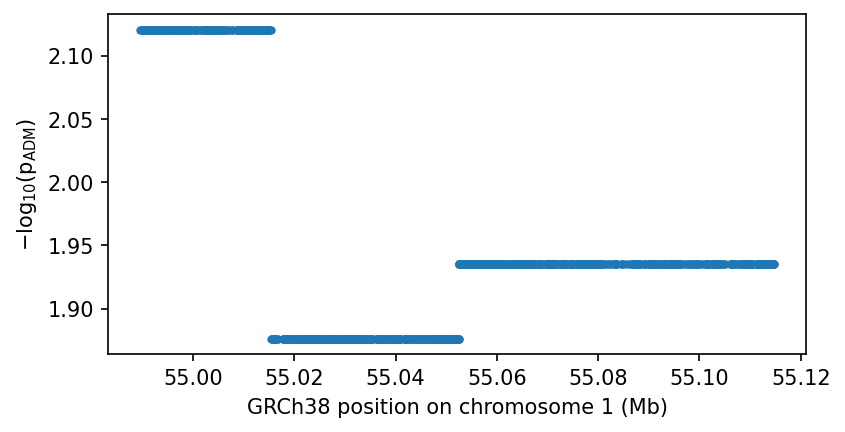

trait: ldl_direct, rsid: rs28362286, att: 2.66e-10, snp1: 3.56e-10, tractor: 2.92e-09


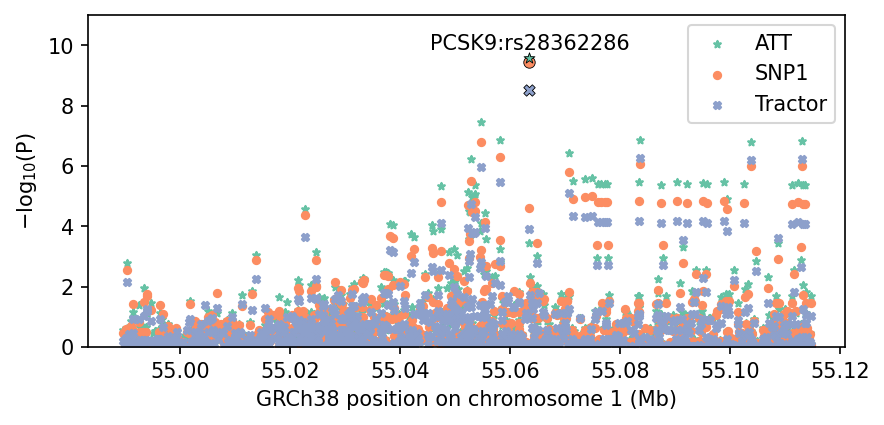

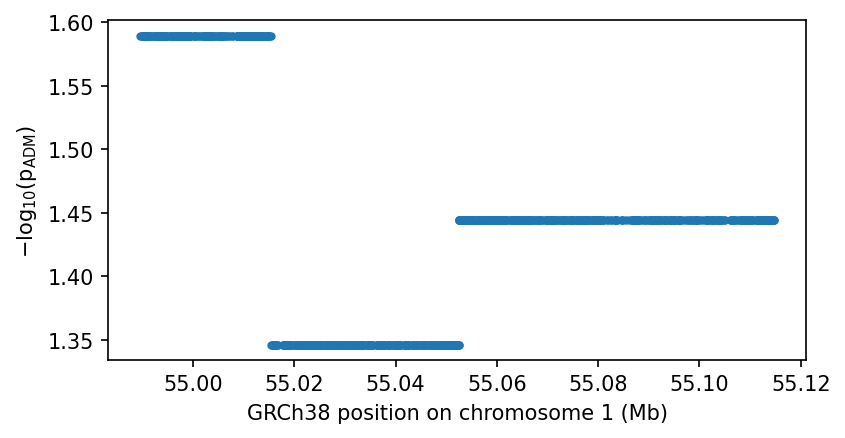

trait: cholesterol, rsid: rs7528419, att: 8.26e-06, snp1: 9.21e-06, tractor: 5.17e-05


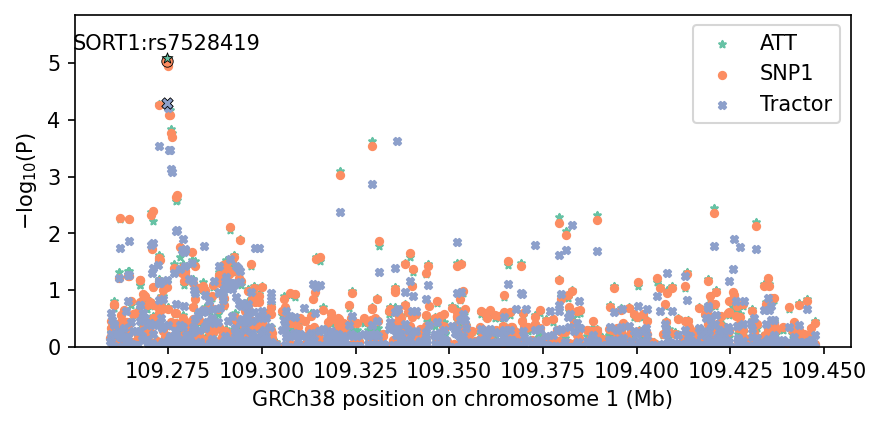

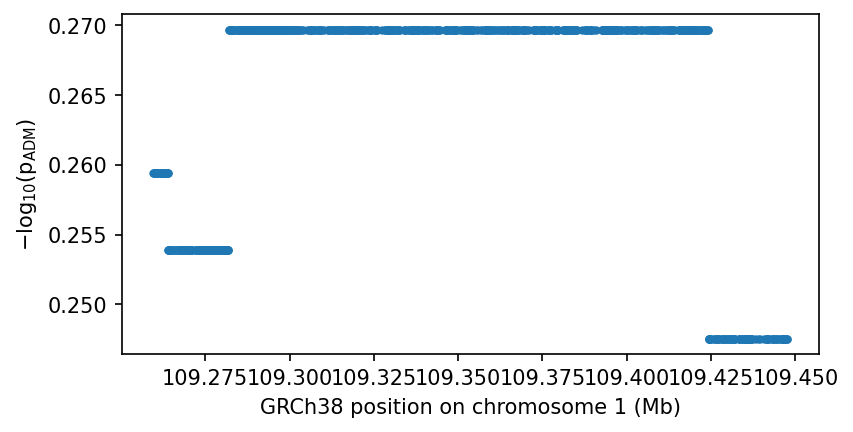

trait: ldl_direct, rsid: rs12740374, att: 7.64e-08, snp1: 8.27e-08, tractor: 5.22e-07


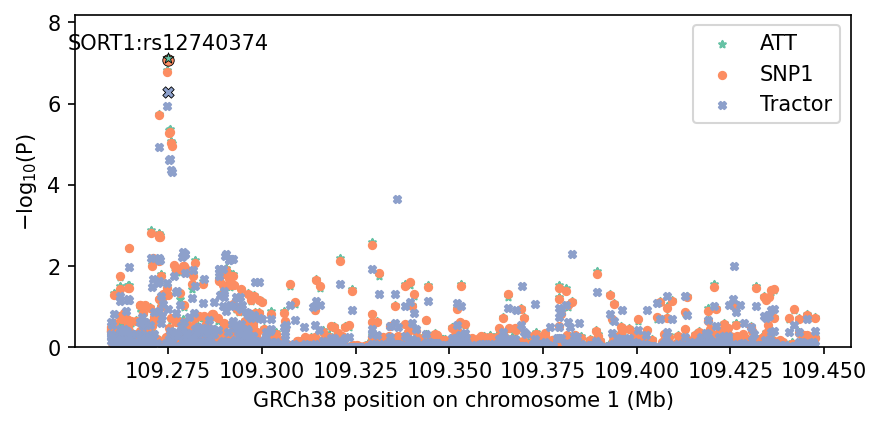

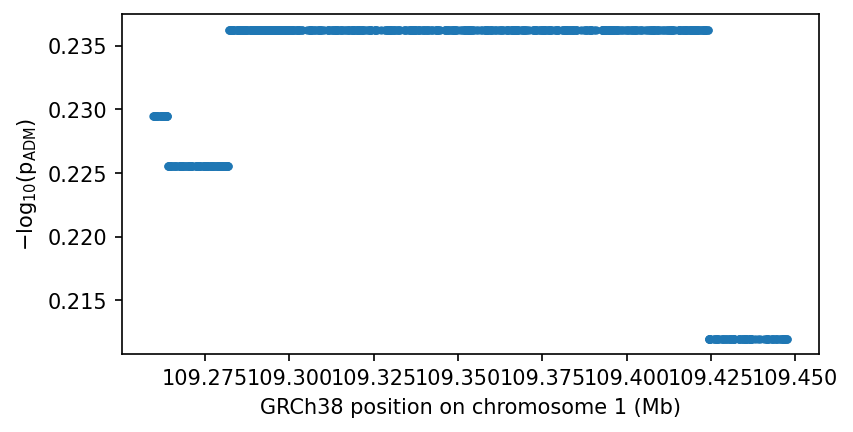

In [48]:
df_pval = {
    "trait": [],
    "loci": [],
    "att": [],
    "snp1": [],
    "tractor": []
}

for gene in dict_region:
    region = dict_region[gene]
    ds_imputed = dict_ds_imputed[gene]
    position = ds_imputed.position.values / 1e6
    for trait in ["cholesterol", "ldl_direct"]:
        ylim = 0
        assoc_att, assoc_snp1, assoc_tractor = ds_imputed[f"assoc_{trait}_att"].values, ds_imputed[f"assoc_{trait}_snp1"].values, ds_imputed[f"assoc_{trait}_tractor"].values
        fig, ax = plt.subplots(dpi=150, figsize=(6, 3))
        
        legends = []
        for i, (label, pval) in enumerate(zip(["ATT", "SNP1", "Tractor"], 
                                               [assoc_att, assoc_snp1, assoc_tractor])):
            
            score = -np.log10(pval)
            ax.scatter(position, score, alpha=1.0, s=12.0, label=label, color=cycle_colors[i], marker=cycle_markers[i])
            # adjust y limit
            ylim = max(max(score), ylim)
        ax.set_xlabel(f"GRCh38 position on chromosome {region[0]} (Mb)")
        ax.set_ylabel("$-\log_{10}(P)$")
#         ax.set_title(f"{trait} {gene}")
        
        index = assoc_tractor.argmin()
        rsid = get_rsid(ds_imputed.snp[index].values.item())
        print(f"trait: {trait}, rsid: {rsid}, att: {assoc_att[index]:.2e}, snp1: {assoc_snp1[index]:.2e}, tractor: {assoc_tractor[index]:.2e}")
        ax.annotate(gene + ":" + rsid, xy=(position[index], -np.log10(assoc_att[index]) * 1.03), ha="center")
        
        for i, pval in enumerate([assoc_att, assoc_snp1, assoc_tractor]):
            zorder = 10 if i == 0 else 1
            score = -np.log10(pval)
            ax.scatter(position[index], score[index], alpha=1.0, s=30.0, color=cycle_colors[i], edgecolors='k', linewidths=0.4, marker=cycle_markers[i], zorder=zorder)
        
        plt.legend()
        plt.tight_layout()
        plt.ylim(0, ylim * 1.15)
        plt.savefig(f"results/locus_{gene}_{trait}.png", bbox_inches='tight', dpi=200)
        plt.show()
    
        df_pval["trait"].append(trait)
        df_pval["loci"].append(gene)
        df_pval["att"].append(assoc_att[index])
        df_pval["snp1"].append(assoc_snp1[index])
        df_pval["tractor"].append(assoc_tractor[index])
        
        fig, ax = plt.subplots(dpi=150, figsize=(6, 3))
        assoc_adm = ds_imputed[f"assoc_{trait}_adm"].values
        ax.scatter(position, -np.log10(assoc_adm), alpha=1.0, s=9.0, label="ADM")
        ax.set_xlabel(f"GRCh38 position on chromosome {region[0]} (Mb)")
        ax.set_ylabel("$-\log_{10}(p_{ADM})$")
        plt.show()

df_pval = pd.DataFrame(df_pval)

In [41]:
df_pval_fmt = df_pval.replace({"ldl_direct": "LDL", "cholesterol": "TC", "hdl_cholesterol": "HDL"})
df_pval_fmt.columns = ["Trait", "Loci", "ATT", "SNP1", "Tractor"]

df_chi2_fmt = df_pval_fmt.copy()
df_chi2_fmt[["ATT", "SNP1", "Tractor"]] = pval2zsc(df_chi2_fmt[["ATT", "SNP1", "Tractor"]]) ** 2

for method in ["SNP1", "Tractor"]:
    df_rel = (df_chi2_fmt[method] - df_chi2_fmt["ATT"]) / df_chi2_fmt["ATT"] * 100
    df_chi2_fmt[method] = df_chi2_fmt[method].round(1).astype(str) + " (" + df_rel.round(1).astype(str) + "%)"
    print(f"{method} relative to ATT, average {df_rel.mean():.1f}%")
df_chi2_fmt["ATT"] = df_chi2_fmt["ATT"].round(1).astype(str)

SNP1 relative to ATT, average -2.2%
Tractor relative to ATT, average -11.9%


In [42]:
display(df_pval_fmt)

,Trait,Loci,ATT,SNP1,Tractor
0,TC,APOE,2.276625e-31,4.701675e-31,1.221194e-29
1,LDL,APOE,9.094678e-51,1.560020e-50,3.219829e-48
2,TC,LDLR,5.586337e-09,6.577368e-09,2.776081e-08
3,LDL,LDLR,2.299625e-10,2.764399e-10,1.645088e-09
4,TC,PCSK9,4.016728e-10,3.425828e-09,2.087586e-08
5,LDL,PCSK9,2.659044e-10,3.557486e-10,2.915067e-09
6,TC,SORT1,8.262382e-06,9.211743e-06,5.169194e-05
7,LDL,SORT1,7.636324e-08,8.274594e-08,5.222555e-07


In [43]:
display(df_chi2_fmt)

,Trait,Loci,ATT,SNP1,Tractor
0,TC,APOE,134.4,132.9 (-1.1%),126.5 (-5.9%)
1,LDL,APOE,223.2,222.1 (-0.5%),211.5 (-5.2%)
2,TC,LDLR,32.6,32.3 (-1.0%),29.5 (-9.5%)
3,LDL,LDLR,38.8,38.5 (-0.9%),35.0 (-9.9%)
4,TC,PCSK9,37.8,33.6 (-11.1%),30.1 (-20.4%)
5,LDL,PCSK9,38.6,38.0 (-1.5%),33.9 (-12.1%)
6,TC,SORT1,18.6,18.3 (-1.1%),15.1 (-18.8%)
7,LDL,SORT1,27.6,27.4 (-0.6%),23.8 (-13.5%)


In [44]:
df_chi2_fmt.to_excel("results/chi2.xlsx", index=False)